In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

In [107]:
# %cd "C:\Users\khakh\skill-up\ML\projects\titanic"
# загружаем данные
# Смотрим на табличку 

df = pd.read_csv(r"data/train.csv", index_col=0)
df.head(10)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [ ]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [99]:
df.shape

(891, 11)

In [96]:
# Сбалансированы ли классы?
df.value_counts('Survived', normalize=True)

Survived
0    0.616162
1    0.383838
dtype: float64

In [97]:
# Видим умеренный дисбаланс 1.6:1

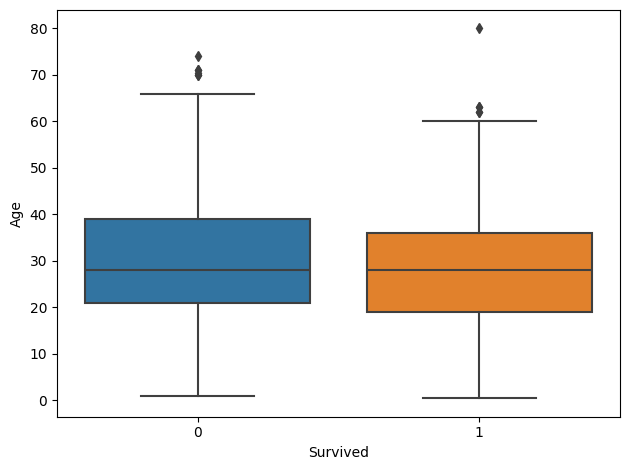

In [120]:
# Для каждого числового признака построим ящик с усами
sns.boxplot(data=df, x="Survived", y="Age")
plt.tight_layout()

In [ ]:
# Предположение, что выживаемость зависит от пола выглядит разумно. Проверим.
cross_Sur_Sex = pd.crosstab(df['Survived'], df['Sex'])

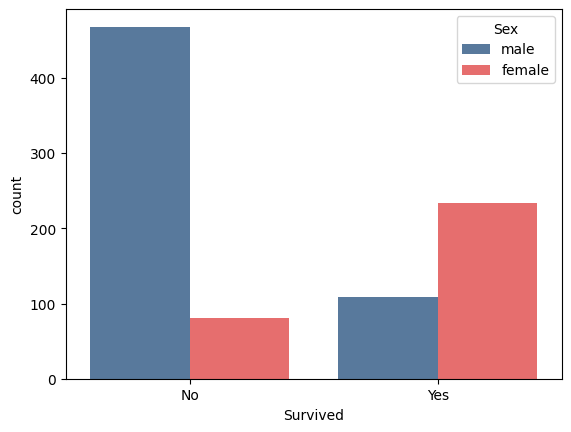

In [59]:
sns.countplot(data=df.replace({'Survived': {0: 'No', 1: 'Yes'}}), x='Survived', hue='Sex', palette={'male': '#4C78A8', 'female': "#FA5A5A"});

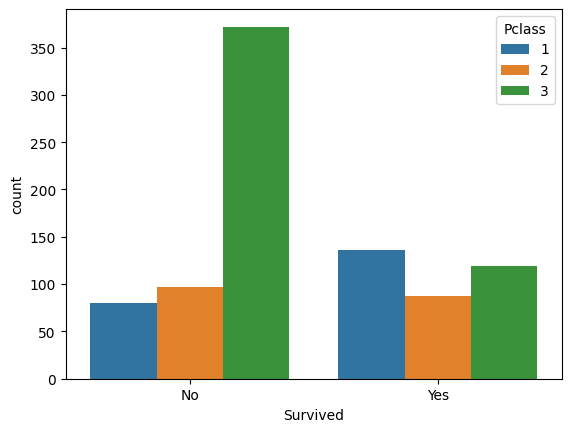

In [84]:
# Зависит ли выживаемость от класса? Проверим
sns.countplot(data=df.replace({'Survived': {0: 'No', 1: 'Yes'}}), x='Survived', hue='Pclass');

В абсолютных значениях выглядит не так информативно. Построим в относительных.

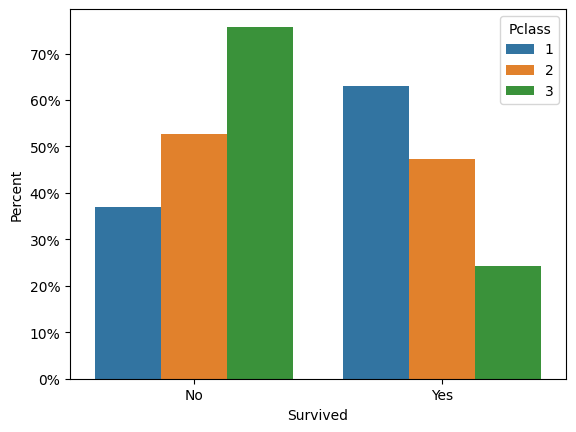

In [93]:
cross_pct = (pd.crosstab(df['Survived'].replace({0: 'No', 1: 'Yes'}), df['Pclass'], normalize='columns')
               .reset_index()
               .melt(id_vars='Survived', var_name='Pclass', value_name='Percent'))
sns.barplot(data=cross_pct, x='Survived', y='Percent', hue='Pclass')
plt.gca().yaxis.set_major_formatter(lambda x,_: f'{x*100:.0f}%')


Видно, что Pclass тоже будет хорошим предиктором.

Видим, что признаки Age, Cabin имеют нули. Заполним Age для начала медианным значением. На начальном этапе не будем использовать Cabin и удалим его из df. 

In [42]:
# заполняем NaN медианным значением
df['Age'] = df['Age'].fillna(df['Age'].median())
# df = df.drop('Cabin', axis=1)

# преобразуем пол в бинарный признак
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']]
df.head()

,Survived,Pclass,Sex,Age,Fare,SibSp,Parch
PassengerId,,,,,,,
1,0,3,0,22.0,7.2500,1,0
2,1,1,1,38.0,71.2833,1,0
3,1,3,1,26.0,7.9250,0,0
4,1,1,1,35.0,53.1000,1,0
5,0,3,0,35.0,8.0500,0,0


In [44]:
# выделим предикторы и цель в отдельные пременные
X = df.drop(columns='Survived')
y = df['Survived']

# разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
knn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier())
])

knn_params = {
    "clf__n_neighbors": [3, 5, 7, 9],
    "clf__weights": ["uniform", "distance"],
    "clf__p": [1, 2]  # 1 = манхэттенб, 2 = евклид
}

knn_grid = GridSearchCV(knn_pipe, knn_params, cv=5, scoring="accuracy")
knn_grid.fit(X, y)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'clf__n_neighbors': [3, 5, ...], 'clf__p': [1, 2], 'clf__weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(random_state=42))
])

rf_params = {
    "clf__n_estimators": [50, 100, 200],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5],
    "clf__max_features": ["sqrt", "log2"]
}

rf_grid = GridSearchCV(rf_pipe, rf_params, cv=5, scoring="accuracy")
rf_grid.fit(X, y)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'clf__max_depth': [None, 5, ...], 'clf__max_features': ['sqrt', 'log2'], 'clf__min_samples_split': [2, 5], 'clf__n_estimators': [50, 100, ...]}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [16]:
print("KNN best:", knn_grid.best_params_)
print("KNN score:", knn_grid.best_score_)

print("RF best:", rf_grid.best_params_)
print("RF score:", rf_grid.best_score_)

KNN best: {'clf__n_neighbors': 5, 'clf__p': 1, 'clf__weights': 'uniform'}
KNN score: 0.8182097796748478
RF best: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 2, 'clf__n_estimators': 50}
RF score: 0.8339275626137719


In [17]:
test = pd.read_csv("../data/test.csv")

# Заполняем пропуски
test['Age'] = test['Age'].fillna(df['Age'].median())
test['Fare'] = test['Fare'].fillna(df['Fare'].median())

# Кодируем пол
test['Sex'] = test['Sex'].map({'male': 0, 'female': 1})

# Выбираем те же признаки
X_final = test[['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']]


In [18]:
final_rf = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        max_depth=10, 
        n_estimators=50, 
        min_samples_split=2, 
        max_features='sqrt',
        random_state=42
    ))
])

final_rf.fit(X, y)  # X, y — из train.csv


,steps,"[('scaler', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_estimators,50
,criterion,'gini'
,max_depth,10
,min_samples_split,2


In [19]:
preds = final_rf.predict(X_final)

In [20]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": preds
})

submission.to_csv("submission.csv", index=False)


<Axes: xlabel='Survived', ylabel='Fare'>

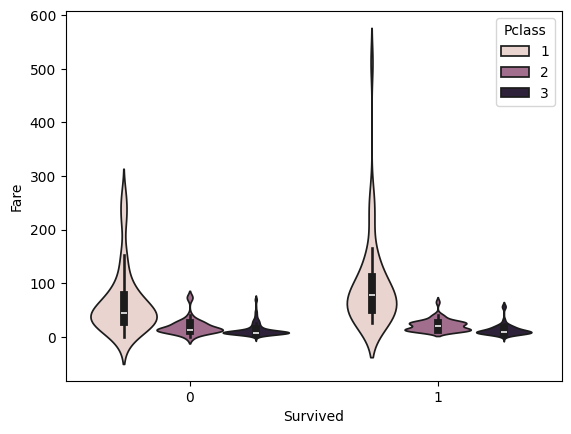

In [25]:
sns.violinplot(df, x='Survived', y='Fare', hue='Pclass')